In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage import io, color, exposure, transform
import cv2


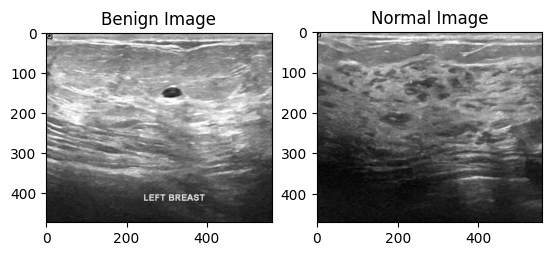

Accuracy: 0.75
Confusion Matrix:
[[2 1]
 [1 4]]


In [ ]:
# Load your ultrasound images (make sure to replace 'benign_path' and 'normal_path' with your actual paths)
benign_path = '/content/gdrive/MyDrive/Colab Notebooks/breast cancer dataset/defective'
normal_path = '/content/gdrive/MyDrive/Colab Notebooks/breast cancer dataset/normal'

def load_images(path):
    images = []
    for filename in os.listdir(path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = io.imread(os.path.join(path, filename))
            images.append(img)
    return images

benign_images = load_images(benign_path)
normal_images = load_images(normal_path)

# Display an example image from each class
plt.subplot(1, 2, 1)
plt.imshow(benign_images[0])
plt.title('Benign Image')

plt.subplot(1, 2, 2)
plt.imshow(normal_images[0])
plt.title('Normal Image')

plt.show()

# Image preprocessing and feature extraction
def preprocess_image(img):
    # Convert the image to grayscale
    gray_img = color.rgb2gray(img)

    # Apply histogram equalization for better contrast
    equalized_img = exposure.equalize_hist(gray_img)

    # Resize the image to a common size
    resized_img = transform.resize(equalized_img, (64, 64))

    # Apply Gaussian blur to reduce noise
    blurred_img = cv2.GaussianBlur(resized_img, (5, 5), 0)

    # Flatten the image as a feature vector
    feature_vector = blurred_img.flatten()

    return feature_vector

# Preprocess and extract features for benign and normal images
benign_features = np.array([preprocess_image(img) for img in benign_images])
normal_features = np.array([preprocess_image(img) for img in normal_images])

# Create labels for the dataset (1 for benign, 0 for normal)
labels = np.concatenate([np.ones(len(benign_features)), np.zeros(len(normal_features))])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.concatenate([benign_features, normal_features]), labels, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)

Image 1: Normal
Image 2: Benign
Image 3: Benign
Image 4: Normal
Image 5: Normal
Image 6: Benign


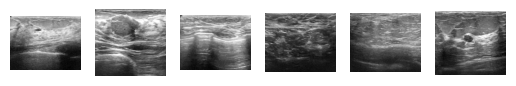

In [ ]:

testing_path = '/content/gdrive/MyDrive/Colab Notebooks/breast cancer dataset/testing'

def load_testing_images(path):
    images = []
    for filename in os.listdir(path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = io.imread(os.path.join(path, filename))
            images.append(img)
    return images

testing_images = load_testing_images(testing_path)

# Preprocess and extract features for testing images
testing_features = np.array([preprocess_image(img) for img in testing_images])

# Standardize the features using the same scaler used for training
testing_features = scaler.transform(testing_features)

# Make predictions on the testing set
predictions = svm_classifier.predict(testing_features)

# Display the results
for i, pred in enumerate(predictions):
    if pred == 1:
        print(f"Image {i+1}: Benign")
    else:
        print(f"Image {i+1}: Normal")

# If you want to visualize the images and their predicted classes, you can do something like this:
for i, img in enumerate(testing_images):
    plt.subplot(1, len(testing_images), i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.show()


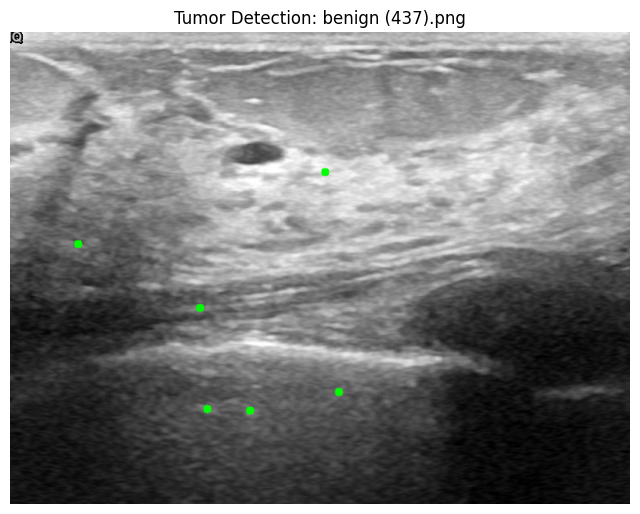

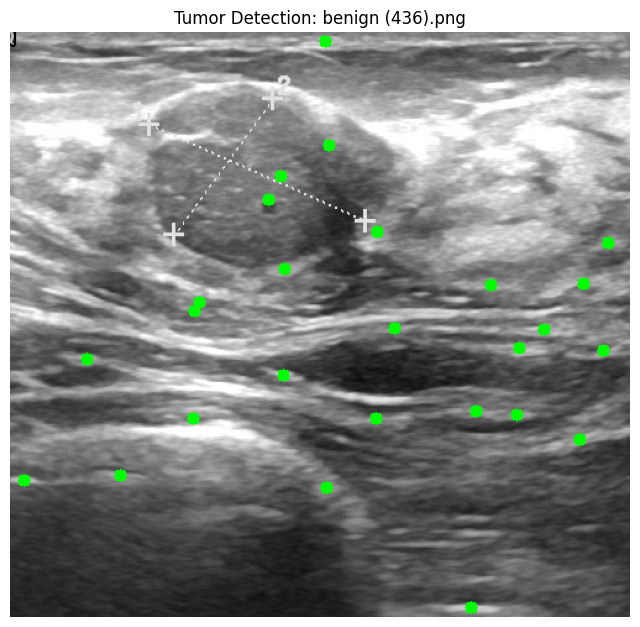

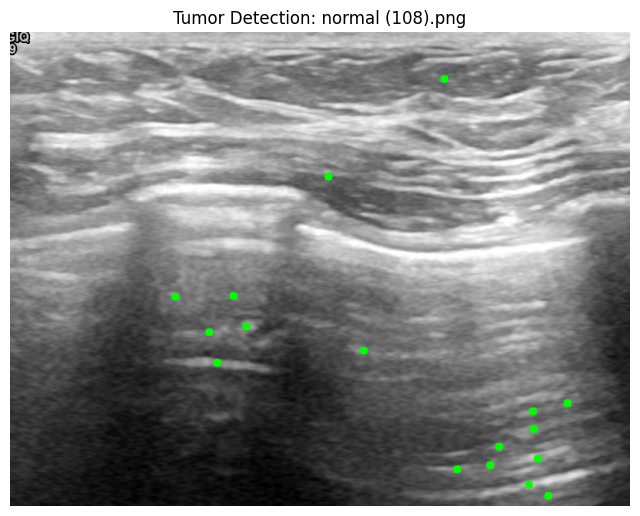

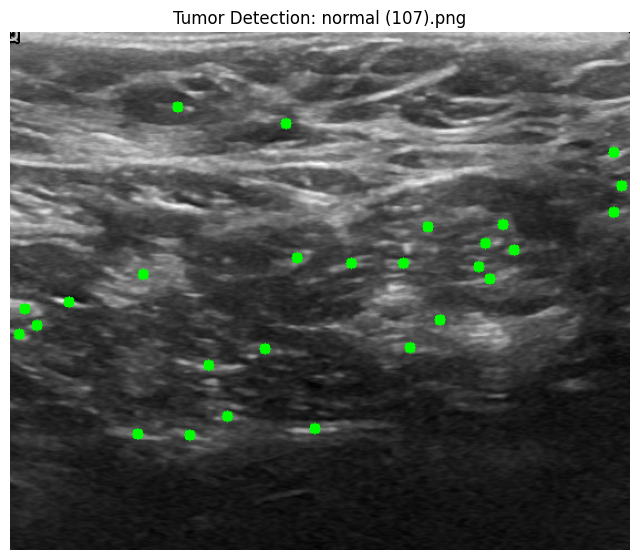

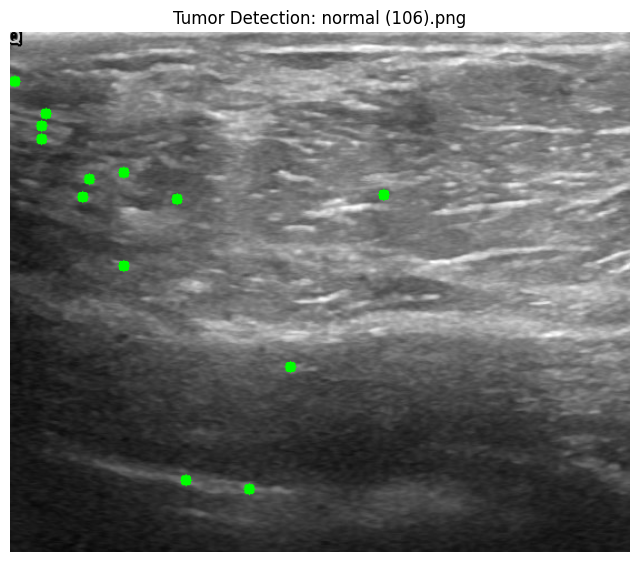

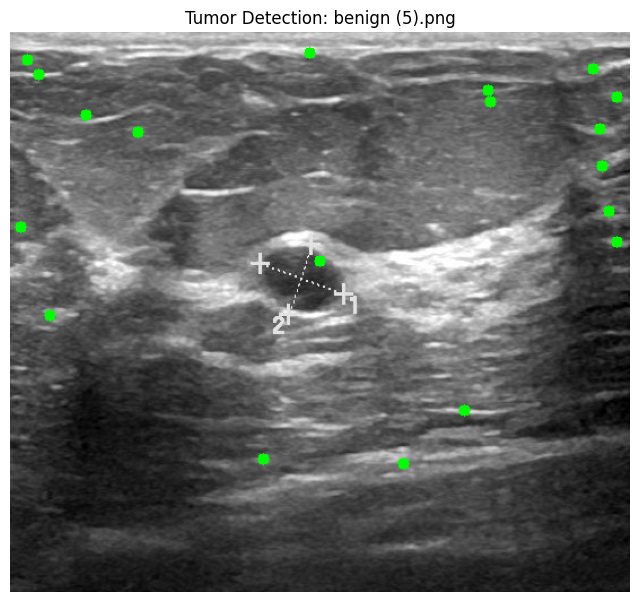

In [ ]:
def extract_tumor_gmm(image):
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Mixture Model (GMM) segmentation
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(gray_img.reshape((-1, 1)))
    gmm_labels = gmm.predict(gray_img.reshape((-1, 1)))

    # Reshape the labels to the original image shape
    gmm_labels = gmm_labels.reshape(gray_img.shape)

    # Extract the tumor region (assuming tumor has a different intensity)
    tumor_region = np.where(gmm_labels == 1, gray_img, 0)

    # Apply adaptive median filter for noise reduction
    adaptive_median = cv2.medianBlur(tumor_region, 15)  # Adjust the kernel size as needed

    # Create a binary mask (0 for non-tumor, 255 for tumor)
    binary_mask = np.where(adaptive_median > 0, 255, 0).astype(np.uint8)

    # Apply the binary mask to the original image
    tumor_detection_img = cv2.bitwise_and(image, image, mask=binary_mask)

    return tumor_detection_img

def process_and_display_images_gmm(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_path)

        result_img = extract_tumor_gmm(img)

        plt.figure(figsize=(6, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image: {image_file}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title('Tumor Extraction (GMM)')
        plt.axis('off')

        plt.show()

# Provide the path to your testing folder
testing_folder_path = '/content/gdrive/MyDrive/Colab Notebooks/breast cancer dataset/testing'

# Process and display images using GMM segmentation
process_and_display_images_gmm(testing_folder_path)


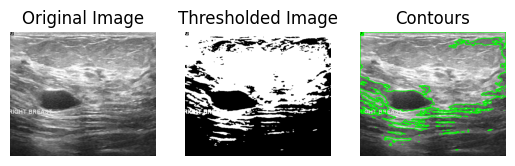

In [ ]:
image_path = '/content/gdrive/MyDrive/Colab Notebooks/breast cancer dataset/defective/benign (2).png'
img = cv2.imread(image_path)

# Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply histogram equalization for better contrast
equalized_img = cv2.equalizeHist(gray_img)

# Apply Gaussian blur to reduce noise
blurred_img = cv2.GaussianBlur(equalized_img, (5, 5), 0)

# Use adaptive thresholding to segment potential tumor regions
_, thresholded_img = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Find contours in the thresholded image
contours, _ = cv2.findContours(thresholded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw contours on
contour_img = img.copy()

# Draw contours on the image
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

# Display the results
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(thresholded_img, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.title('Contours')
plt.axis('off')

plt.show()



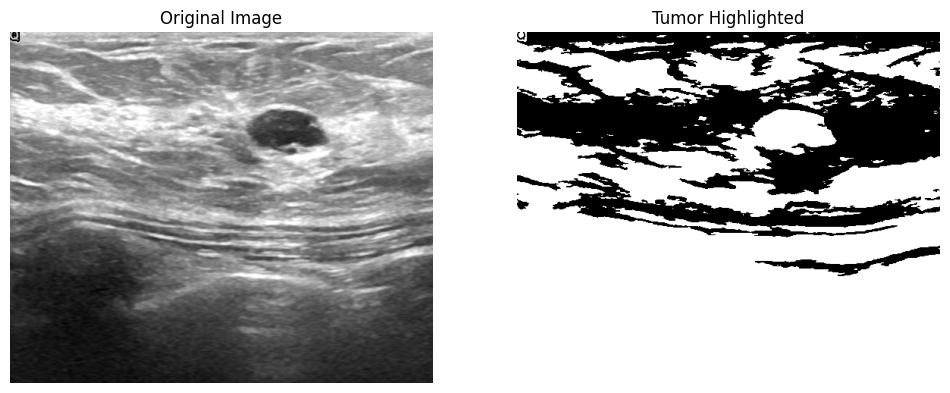

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def read_image(file_path):
    return cv2.imread(file_path)

def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def apply_threshold(image, threshold_value):
    _, binary_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    return binary_image

def invert_image(image):
    return cv2.bitwise_not(image)

def find_contours(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def draw_contours(image, contours):
    result_image = image.copy()
    cv2.drawContours(result_image, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
    return result_image

def breast_cancer_detection(image_path, threshold_value):
    # Read the image
    original_image = read_image(image_path)

    # Convert the image to grayscale
    gray_image = convert_to_grayscale(original_image)

    # Apply thresholding
    binary_image = apply_threshold(gray_image, threshold_value)

    # Invert the binary image
    inverted_image = invert_image(binary_image)

    # Find contours
    contours = find_contours(inverted_image)

    # Draw contours on a black background
    result_image = np.zeros_like(original_image)
    result_image = draw_contours(result_image, contours)

    # Display the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title('Tumor Highlighted')
    plt.axis('off')

    plt.show()

# Provide the path to your breast cancer image
image_path = '/content/gdrive/MyDrive/Colab Notebooks/breast cancer dataset/defective/benign (17).png'

# Set the threshold value (you may need to experiment with this value)
threshold_value = 150

breast_cancer_detection(image_path, threshold_value)
